<a href="https://colab.research.google.com/github/Sindhuhar/practice_AI_projects/blob/main/breaking_captchas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breaking captchas with deep learning, Keras, and TensorFlow


### Import Packages

In [2]:
# import the necessary packages
from pyimagesearch.utils.captchahelper import preprocess
from pyimagesearch.nn.conv import LeNet
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from imutils import contours
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import argparse
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Training the Captcha Breaker

In [4]:
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-m", "--model", required=True,
# 	help="path to output model")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "dataset",
	"model": "output/lenet.hdf5",
}

In [5]:
# initialize the data and labels
data = []
labels = []

In [6]:
# loop over the input images
for imagePath in paths.list_images(args["dataset"]):
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = preprocess(image, 28, 28)
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

In [7]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [9]:
# convert the labels from integers to vectors
lb = LabelBinarizer().fit(trainY)
trainY = lb.transform(trainY)
testY = lb.transform(testY)

In [10]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=9)
opt = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [11]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY,  validation_data=(testX, testY),
	batch_size=32, epochs=15, verbose=1)

[INFO] training network...
Epoch 1/15
48/48 [==============================] - 10s 174ms/step - loss: 2.1577 - accuracy: 0.2624 - val_loss: 2.1381 - val_accuracy: 0.3380
Epoch 2/15
48/48 [==============================] - 9s 195ms/step - loss: 2.0814 - accuracy: 0.3300 - val_loss: 2.0326 - val_accuracy: 0.5209
Epoch 3/15
48/48 [==============================] - 9s 178ms/step - loss: 1.9102 - accuracy: 0.5639 - val_loss: 1.8420 - val_accuracy: 0.4215
Epoch 4/15
48/48 [==============================] - 7s 155ms/step - loss: 1.4693 - accuracy: 0.7369 - val_loss: 1.5504 - val_accuracy: 0.3936
Epoch 5/15
48/48 [==============================] - 8s 173ms/step - loss: 0.7515 - accuracy: 0.9437 - val_loss: 0.5000 - val_accuracy: 0.9602
Epoch 6/15
48/48 [==============================] - 4s 73ms/step - loss: 0.2568 - accuracy: 0.9927 - val_loss: 0.1416 - val_accuracy: 1.0000
Epoch 7/15
48/48 [==============================] - 3s 72ms/step - loss: 0.1006 - accuracy: 0.9987 - val_loss: 0.0857 - v

In [12]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
16/16 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00        42
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        51
           8       1.00      1.00      1.00        71
           9       1.00      1.00      1.00        63

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [13]:
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"])

[INFO] serializing network...


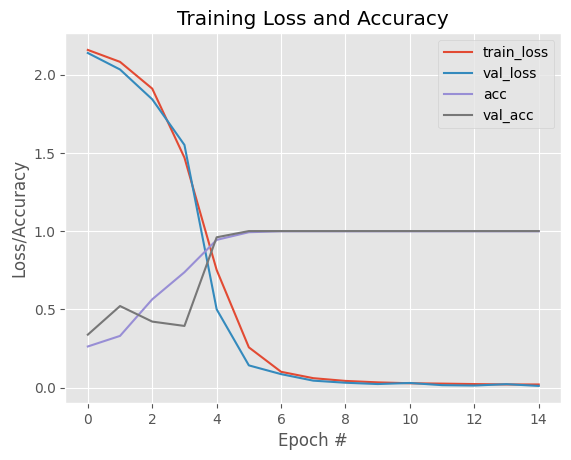

In [14]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Testing the Captcha Breaker

In [15]:
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input directory of images")
# ap.add_argument("-m", "--model", required=True,
# 	help="path to input model")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "downloads",
	"model": "output/lenet.hdf5",
}

In [16]:
# load the pre-trained network
print("[INFO] loading pre-trained network...")
model = load_model(args["model"])

[INFO] loading pre-trained network...


In [17]:
# randomy sample a few of the input images
imagePaths = list(paths.list_images(args["input"]))
imagePaths = np.random.choice(imagePaths, size=(10,),
	replace=False)

1/1 [==============================] - 0s 24ms/step
[INFO] captcha: 2616


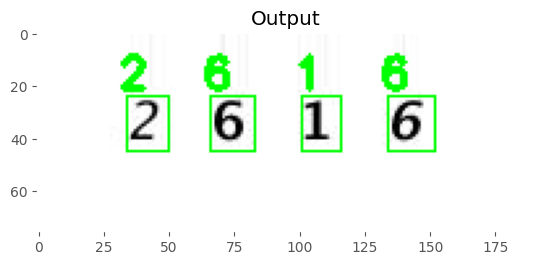

1/1 [==============================] - 0s 23ms/step
[INFO] captcha: 5943


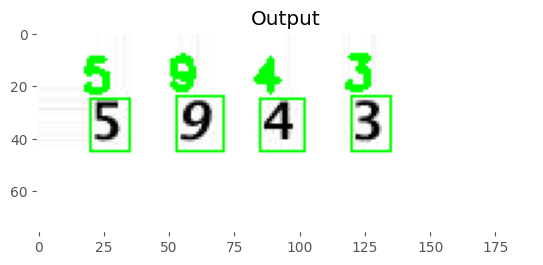

1/1 [==============================] - 0s 23ms/step
[INFO] captcha: 6463


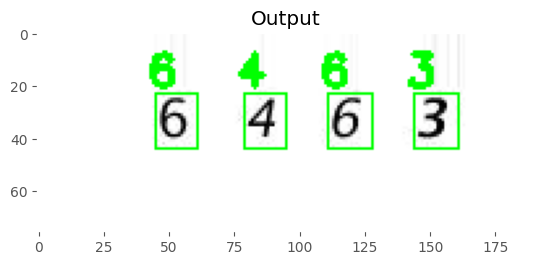

1/1 [==============================] - 0s 36ms/step
[INFO] captcha: 2572


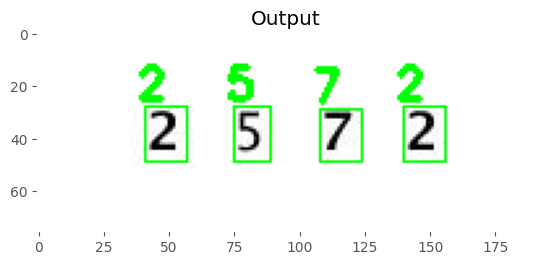

1/1 [==============================] - 0s 24ms/step
[INFO] captcha: 1821


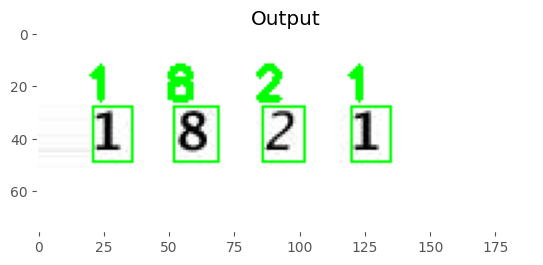

1/1 [==============================] - 0s 27ms/step
[INFO] captcha: 8579


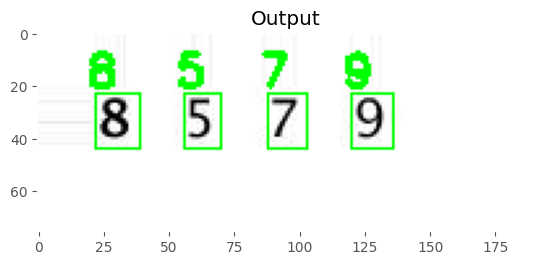

1/1 [==============================] - 0s 41ms/step
[INFO] captcha: 2619


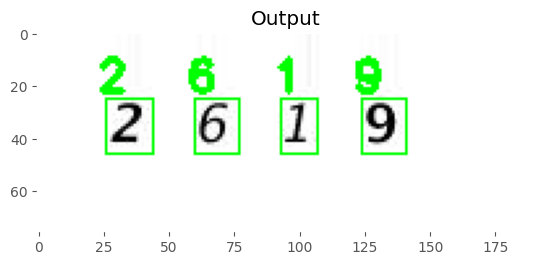

1/1 [==============================] - 0s 35ms/step
[INFO] captcha: 4851


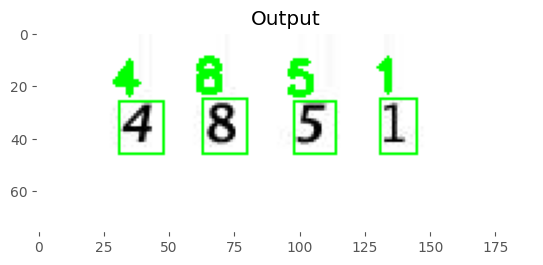

1/1 [==============================] - 0s 38ms/step
[INFO] captcha: 2553


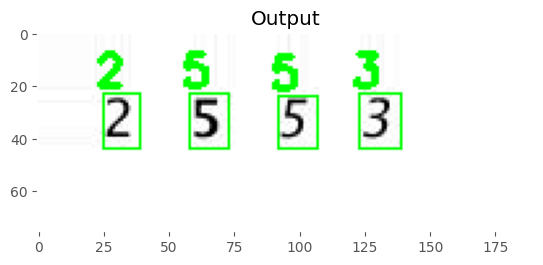

1/1 [==============================] - 0s 35ms/step
[INFO] captcha: 5728


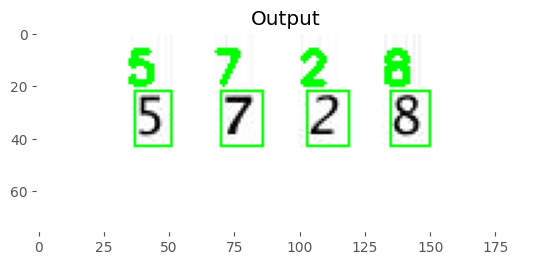

In [18]:
# loop over the image paths
for imagePath in imagePaths:
	# load the image and convert it to grayscale, then pad the image
	# to ensure digits caught only the border of the image are
	# retained
	image = cv2.imread(imagePath)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20,
		cv2.BORDER_REPLICATE)

	# threshold the image to reveal the digits
	thresh = cv2.threshold(gray, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	# find contours in the image, keeping only the four largest ones,
	# then sort them from left-to-right
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
	cnts = contours.sort_contours(cnts)[0]

	# initialize the output image as a "grayscale" image with 3
	# channels along with the output predictions
	output = cv2.merge([gray] * 3)
	predictions = []

	# loop over the contours
	for c in cnts:
		# compute the bounding box for the contour then extract the
		# digit
		(x, y, w, h) = cv2.boundingRect(c)
		roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]

		# pre-process the ROI and classify it then classify it
		roi = preprocess(roi, 28, 28)
		roi = np.expand_dims(img_to_array(roi), axis=0) / 255.0
		pred = model.predict(roi).argmax(axis=1)[0] + 1
		predictions.append(str(pred))

		# draw the prediction on the output image
		cv2.rectangle(output, (x - 2, y - 2),
			(x + w + 4, y + h + 4), (0, 255, 0), 1)
		cv2.putText(output, str(pred), (x - 5, y - 5),
			cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

	# show the output image
	print("[INFO] captcha: {}".format("".join(predictions)))
	plt_imshow("Output", output)